In [1]:
import numpy as np
import pandas as pd
import glob
import emcee
import corner
import scipy.stats
from scipy.ndimage import gaussian_filter1d

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

from fit_just_early_lc import prep_light_curve
from uncertain_x.line_fit import uncertain_x

from multiprocessing import Pool
import time

from corner_hack import corner_hack
from light_curve_plot import f_t, plot_both_filt

In [2]:
%matplotlib notebook

In [3]:
info_path="../../forced_lightcurves/sample_lc_v2/"
salt_df = pd.read_csv(info_path + "../../Nobs_cut_salt2_spec_subtype_pec.csv")
res = pd.read_csv('results_40percent.csv')

In [4]:
normal = np.where((salt_df['Ia subtype'] != 'Ia-CSM') & 
                  (salt_df['Ia subtype'] != 'SC') & 
                  (salt_df['Ia subtype'] != 'SC*') & 
                  (salt_df['Ia subtype'] != '86G-like') & 
                  (salt_df['Ia subtype'] != '02cx-like'))
good = np.where(res.final_selection.values == 1)
has_host_z = np.where(salt_df.z_source != 'Msl')

normal_good = np.intersect1d(normal, good)
normal_good_host = np.intersect1d(normal_good, has_host_z)

# rearange for plotting
normal_plot = np.setdiff1d(normal[0], normal_good)
normal_good_plot = np.setdiff1d(normal_good, normal_good_host)

print('there are {} normal SNe in sample'.format(len(normal[0])))
print('there are {} normal-reliable SNe in sample'.format(len(normal_good)))
print('there are {} normal-reliable-zhost SNe in sample'.format(len(normal_good_host)))

there are 120 normal SNe in sample
there are 47 normal-reliable SNe in sample
there are 25 normal-reliable-zhost SNe in sample


In [5]:
# plotting dictionary
color_dict = {'orange': '#F0810F',
              'blueberry': '#063852',
              'dark navy': '#011A27'}

## Rise-Time constraints

In [13]:
np.where(salt_df.t0_salt2_unc != salt_df.t0_g_adopted_unc)

(array([26, 38, 56, 61, 68, 81]),)

In [6]:
bw_df = pd.read_csv('kde_bandwidths_uninformative.csv')

In [14]:
pdf_array_tfl = np.zeros((len(res), 100000))
prop_unc_arr = np.zeros((len(res), 100000))

def get_pdf(tup):

    sn, bw = tup
    sn_num = np.where(salt_df.name == sn)[0]
    
    h5_file = info_path + 'big_unc/{}_emcee_40_varchange.h5'.format(sn)
    reader = emcee.backends.HDFBackend(h5_file)
    thin_by = 100
    nsteps = thin_by*np.shape(reader.get_chain())[0]
    tau = reader.get_autocorr_time(tol=0)
    burnin = int(5*np.max(tau))
    samples = reader.get_chain(discard=burnin, thin=np.max(int(np.max(tau)), 0), flat=True)

    t_max_unc = salt_df.t0_g_adopted_unc.iloc[np.where(salt_df.name == sn)].values[0] # SALT B for normal SNe, g poly for others

    t_grid = np.linspace(-25,-5,100000)
    
    if t_max_unc == salt_df.t0_salt2_unc.iloc[np.where(salt_df.name == sn)].values[0]:
        # correct to B band max from g_ztf max
        t_B_max = salt_df.t0_B_salt2.iloc[np.where(salt_df.name == sn)].values[0]
        t_g_max = salt_df.t0_g_adopted.iloc[np.where(salt_df.name == sn)].values[0]
        z_sn = salt_df.z_adopt.iloc[np.where(salt_df.name == sn)].values[0]

        t_fl_samples = samples[:,0] + (t_g_max - t_B_max)/(1 + z_sn)
    else:
        print(sn)
        t_fl_samples = samples[:,0]
    t_fl_data = np.reshape(t_fl_samples, (len(t_fl_samples), 1))

    kde = KernelDensity(rtol=1e-4, bandwidth = bw)
    kde.fit(t_fl_data)

    pdf = kde.score_samples(t_grid.reshape(100000,1))
    
    prop_unc = gaussian_filter1d(np.exp(pdf), t_max_unc/(np.ptp(t_grid)/len(t_grid)),
                             mode='nearest')

    pdf_array_tfl[sn_num] = pdf
    prop_unc_arr[sn_num] = prop_unc
    
    return (pdf, prop_unc)

pool = Pool()

t_fl_res = pool.map(get_pdf, zip(bw_df.ztf_name.values, bw_df.tfl_bw.values))

ZTF18aawpcel
ZTF18abclfee
ZTF18aaykjei
ZTF18abdpvnd
ZTF18abddmrf
ZTF18abhpgje


In [15]:
t_grid = np.linspace(-25,-5,100000)

pdf_array_tfl = np.array(t_fl_res)[:,0]
prop_unc_arr = np.array(t_fl_res)[:,1]

norm_likelihood = np.sum(prop_unc_arr, axis=1)/len(t_grid)*np.ptp(t_grid)
norm_pdf_array = np.log(prop_unc_arr) - np.repeat(np.log(norm_likelihood).reshape(-1,1), len(t_grid), axis=1)

/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


In [16]:
mean_fl = np.sum(norm_pdf_array, axis=0)

norm_mean = np.sum(np.exp(mean_fl - np.max(mean_fl)))/len(t_grid)*np.ptp(t_grid)
mean_pdf_tfl = mean_fl - np.max(mean_fl) - np.repeat(np.log(norm_mean), len(t_grid))

/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in subtract
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


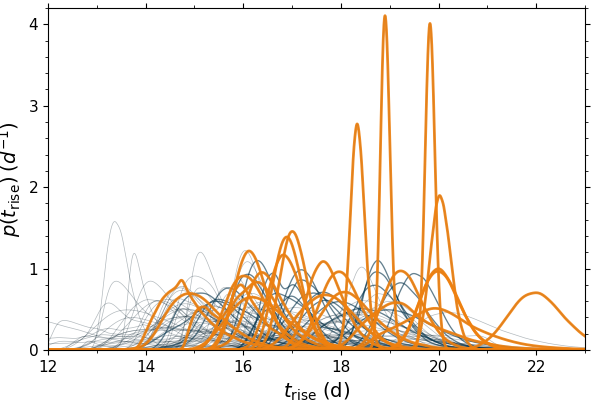

In [17]:
fig, ax = plt.subplots(figsize=(6,4))
for pdf_tfl in norm_pdf_array[normal]:
    ax.plot(-1*t_grid[::-1], np.exp(pdf_tfl[::-1]), 
            color=color_dict['dark navy'], lw=0.5, alpha=0.3)
for pdf_tfl in norm_pdf_array[normal_good]:
    ax.plot(-1*t_grid[::-1], np.exp(pdf_tfl[::-1]), 
            color=color_dict['blueberry'], lw=1, alpha=0.5)
for pdf_tfl in norm_pdf_array[normal_good_host]:
    ax.plot(-1*t_grid[::-1], np.exp(pdf_tfl[::-1]), 
            color=color_dict['orange'], lw=2, alpha=0.9)
    
# plt.plot(t_grid, mean_pdf_tfl, 'k', lw=1)
# plt.yscale('log')
ax.set_xlim(12,23)
ax.set_ylim(0,4.2)
ax.set_xlabel('$t_\mathrm{rise}$ (d)',fontsize=14)
ax.set_ylabel(r'$p(t_\mathrm{rise}) \; (d^{-1})$',fontsize=14)

ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.tick_params(right=True, top=True, bottom=True, which='both', labelsize=11)

fig.subplots_adjust(left=0.08,bottom=0.125,top=0.98,right=0.975)
# fig.savefig('../paper/figures/rise_time.pdf')



# ### plot for poster ###

# fig1, ax1 = plt.subplots(figsize=(10,5))
# for pdf_tfl in norm_pdf_array[normal]:
#     ax1.plot(-1*t_grid[::-1], np.exp(pdf_tfl[::-1]), 
#             color=color_dict['dark navy'], lw=0.5, alpha=0.3)
# for pdf_tfl in norm_pdf_array[normal_good]:
#     ax1.plot(-1*t_grid[::-1], np.exp(pdf_tfl[::-1]), 
#             color=color_dict['blueberry'], lw=1, alpha=0.5)
# for pdf_tfl in norm_pdf_array[normal_good_host]:
#     ax1.plot(-1*t_grid[::-1], np.exp(pdf_tfl[::-1]), 
#             color=color_dict['orange'], lw=2, alpha=0.9)
    
# # plt.plot(t_grid, mean_pdf_tfl, 'k', lw=1)
# # plt.yscale('log')
# ax1.set_xlim(12,23)
# ax1.set_ylim(0,4.2)
# ax1.set_xlabel('$t_\mathrm{rise}$ (d)',fontsize=28)
# ax1.set_ylabel(r'$p(t_\mathrm{rise}) \; (d^{-1})$',fontsize=28)

# ax1.xaxis.set_minor_locator(MultipleLocator(0.25))
# ax1.xaxis.set_major_locator(MultipleLocator(1))
# ax1.yaxis.set_minor_locator(MultipleLocator(0.25))
# ax1.yaxis.set_major_locator(MultipleLocator(1))
# ax1.tick_params(right=True, top=True, bottom=True, which='both', labelsize=20)

# fig1.subplots_adjust(left=0.07,bottom=0.14,top=0.98,right=0.98)
# fig1.savefig('poster_rise_time.pdf')


# ax1.axvspan(0,1e4, facecolor='white')
# fig1.subplots_adjust(left=0.08,bottom=0.165,top=0.98,right=0.98)
# fig1.savefig('poster_rise_time.png', transparent=True)

<IPython.core.display.Javascript object>


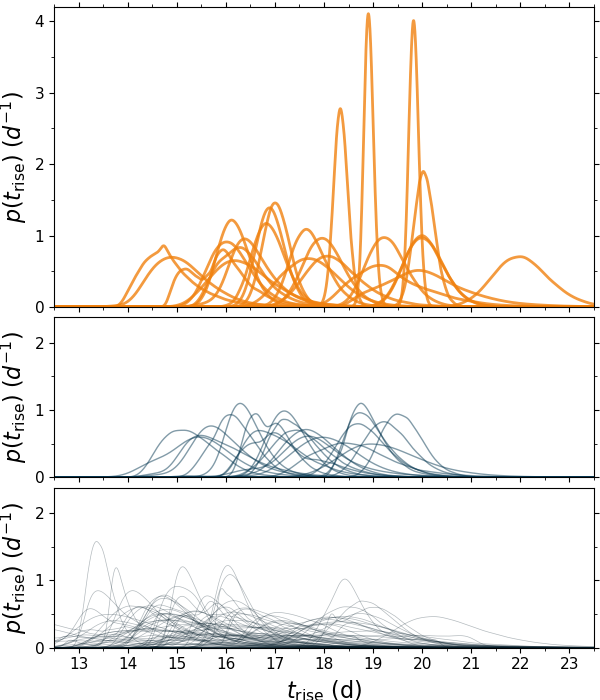

In [27]:
talk_plot = False
if talk_plot:
    figsize = (9,9)
else:
    figsize = (6,7)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, 
                                    figsize=figsize, sharex=True, 
                                    gridspec_kw={'width_ratios': [1],
                                                 'height_ratios':[3,1.6,1.6]})



for pdf_tfl in norm_pdf_array[normal_plot]:
    ax3.plot(-1*t_grid[::-1], np.exp(pdf_tfl[::-1]),
            color=color_dict['dark navy'], lw=0.5, alpha=0.3)
for pdf_tfl in norm_pdf_array[normal_good_plot]:
    ax2.plot(-1*t_grid[::-1], np.exp(pdf_tfl[::-1]),
            color=color_dict['blueberry'], lw=1, alpha=0.5)
for pdf_tfl in norm_pdf_array[normal_good_host]:
    ax1.plot(-1*t_grid[::-1], np.exp(pdf_tfl[::-1]),
            color=color_dict['orange'], lw=2, alpha=0.8)

ax1.set_ylim(0,4.2)
ax2.set_ylim(0,4.2*1.7/3)
ax3.set_ylim(0,4.2*1.7/3)
ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.xaxis.set_major_locator(MultipleLocator(2))


ax.set_xlabel('$t_\mathrm{rise}$ (d)',fontsize=14)
ax.set_ylabel(r'$p(t_\mathrm{rise}) \; (d^{-1})$',fontsize=14)


if talk_plot:
    ax1.set_xlim(12,23)
    ax1.tick_params(top=True, which='both')
    ax3.set_xlabel('$t_\mathrm{rise}$ (d)',fontsize=17)

    for ax in [ax1, ax2, ax3]:
        ax.set_ylabel(r'$p(t_\mathrm{rise}) \; (d^{-1})$',fontsize=17)
        ax.yaxis.set_minor_locator(MultipleLocator(0.5))
        ax.yaxis.set_major_locator(MultipleLocator(1))
        ax.tick_params(right=True, top=False, bottom=True, which='both', labelsize=13)
        ax.vlines(2.0, -10, 10, colors='0.4', linestyles='--')
    
    fig.subplots_adjust(left=0.065,bottom=0.065,top=0.99,right=0.99,hspace=0.05)
else:
    for ax in [ax1, ax2, ax3]:
        ax.set_ylabel(r'$p(t_\mathrm{rise}) \; (d^{-1})$',fontsize=16)
        ax.yaxis.set_minor_locator(MultipleLocator(0.5))
        ax.yaxis.set_major_locator(MultipleLocator(1))
        ax.xaxis.set_minor_locator(MultipleLocator(0.5))
        ax.xaxis.set_major_locator(MultipleLocator(1))
        ax.tick_params(right=True, top=False, bottom=True, which='both', labelsize=11)

    ax1.set_xlim(12.5,23.5)
    ax1.tick_params(top=True, which='both')
    ax3.set_xlabel('$t_\mathrm{rise}$ (d)',fontsize=16)

    fig.subplots_adjust(left=0.09,bottom=0.075,top=0.99,right=0.99,hspace=0.05)
    fig.savefig('../paper/figures/rise_time.pdf')

<IPython.core.display.Javascript object>


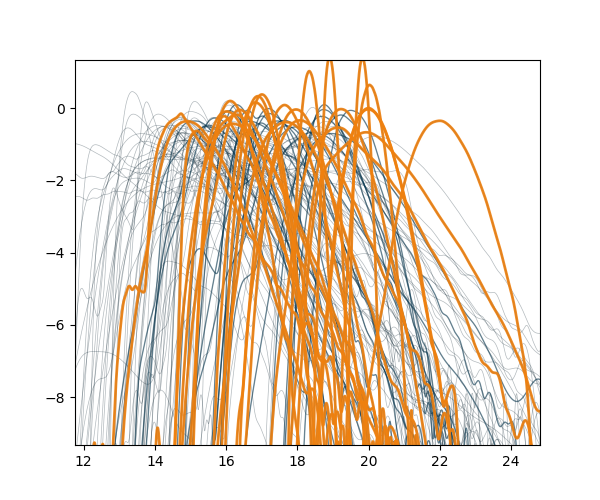

In [21]:
fig, ax = plt.subplots(figsize=(6,5))
for pdf_tfl in norm_pdf_array[normal]:
    ax.plot(-1*t_grid[::-1], pdf_tfl[::-1], 
            color=color_dict['dark navy'], lw=0.5, alpha=0.3)
for pdf_tfl in norm_pdf_array[normal_good]:
    ax.plot(-1*t_grid[::-1], pdf_tfl[::-1], 
            color=color_dict['blueberry'], lw=1, alpha=0.5)
for pdf_tfl in norm_pdf_array[normal_good_host]:
    ax.plot(-1*t_grid[::-1], pdf_tfl[::-1], 
            color=color_dict['orange'], lw=2, alpha=0.9)


In [22]:
low_z_good = np.where((salt_df['Ia subtype'] != 'Ia-CSM') & 
                      (salt_df['Ia subtype'] != 'SC') & 
                      (salt_df['Ia subtype'] != 'SC*') & 
                      (salt_df['Ia subtype'] != '86G-like') & 
                      (salt_df['Ia subtype'] != '02cx-like') & 
                      (res.final_selection.values == 1) & 
                      (salt_df.z_adopt < 0.06))

<IPython.core.display.Javascript object>


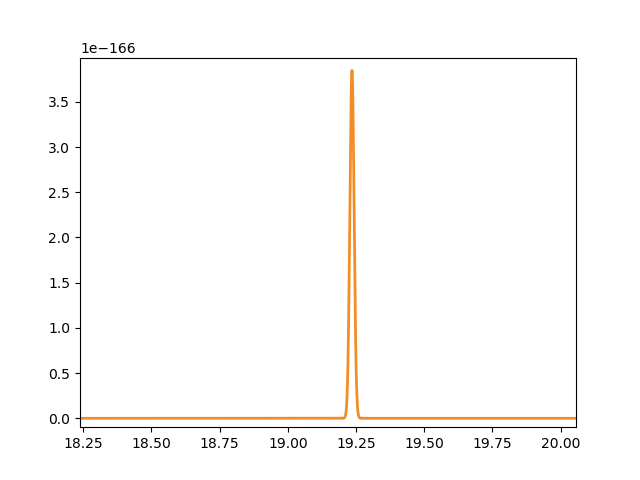

In [23]:
fig, ax = plt.subplots()

ax.plot(-1*t_grid[::-1], np.exp(np.sum(norm_pdf_array[low_z_good], axis=0))[::-1], 
            color=color_dict['orange'], lw=2, alpha=0.9)

## Get Rise Time Uncertainties

In [29]:
t_rise_05 = np.zeros(len(res))
t_rise_16 = np.zeros_like(t_rise_05)
t_rise_50 = np.zeros_like(t_rise_05)
t_rise_84 = np.zeros_like(t_rise_05)
t_rise_95 = np.zeros_like(t_rise_05)

for sn_num, pdf in enumerate(norm_pdf_array):
    cum_prob = np.cumsum(np.exp(pdf)/len(t_grid)*np.ptp(t_grid))
    idx_05 = np.min(np.where(cum_prob > 0.05)[0])
    t_rise_95[sn_num] = -1*np.interp(0.05, cum_prob[idx_05-1:idx_05+1], t_grid[idx_05-1:idx_05+1])
    idx_16 = np.min(np.where(cum_prob > 0.15865)[0])
    t_rise_84[sn_num] = -1*np.interp(0.15865, cum_prob[idx_16-1:idx_16+1], t_grid[idx_16-1:idx_16+1])
    idx_50 = np.min(np.where(cum_prob > 0.5)[0])
    t_rise_50[sn_num] = -1*np.interp(0.50, cum_prob[idx_50-1:idx_50+1], t_grid[idx_50-1:idx_50+1])
    idx_84 = np.min(np.where(cum_prob > 0.84135)[0])
    t_rise_16[sn_num] = -1*np.interp(0.84135, cum_prob[idx_84-1:idx_84+1], t_grid[idx_84-1:idx_84+1])
    idx_95 = np.min(np.where(cum_prob > 0.95)[0])
    t_rise_05[sn_num] = -1*np.interp(0.95, cum_prob[idx_95-1:idx_95+1], t_grid[idx_95-1:idx_95+1])

In [30]:
res['t_rise_05'] = t_rise_05
res['t_rise_16'] = t_rise_16
res['t_rise_50'] = t_rise_50
res['t_rise_84'] = t_rise_84
res['t_rise_95'] = t_rise_95

res.to_csv('results_40percent.csv', index=False)

In [31]:
res = pd.read_csv('results_40percent.csv')

t_rise_16 = res.t_rise_16.values.copy()
t_rise_50 = res.t_rise_50.values.copy()
t_rise_84 = res.t_rise_84.values.copy()

sigma_i = (t_rise_84-t_rise_16)/2
w_i = (sigma_i)**(-2)

In [32]:
print('The following are summary statistics for rise time:')
print('mean, median, weighted mean: {:.5f}, {:.5f}, {:.5f}'.format(np.mean(t_rise_50[normal]), np.median(t_rise_50[normal]),
                                                                   np.average(t_rise_50[normal], 
                                                                              weights=w_i[normal])))
print('std, sMAD, sigma w_mean: {:.5f}, {:.5f}, {:.5f}'.format(np.std(t_rise_50[normal], ddof=1), 
                                                       1.4826*np.median(np.abs(t_rise_50[normal] - np.median(t_rise_50[normal]))),
                                                       1/np.sum(w_i[normal])*np.sqrt(np.sum((w_i[normal]*sigma_i[normal])**2))))

salt_uninformative = uncertain_x.UncertainAbscissa('salt')
salt_uninformative.add_data(salt_df.x1_salt2.values[normal], t_rise_50[normal], 
                            salt_df.x1_salt2_unc.values[normal], sigma_i[normal])
salt_uninformative.mle_slope_intercept(slope_guess=1.0, intercept_guess=17)
print('the slope is: {:.4f} +/- {:.4f}'.format(salt_uninformative.m, salt_uninformative.m_unc))
print('the intercept is: {:.4f} +/- {:.4f}'.format(salt_uninformative.b, salt_uninformative.b_unc))

residuals = t_rise_50[normal] - np.polyval([salt_uninformative.m, salt_uninformative.b], 
                                                salt_df.x1_salt2.values[normal])
print('the residual scatter is: {:.4f} d'.format(np.std(residuals, ddof=1)))
print(' ')
print('  If you restrict to only "good" SNe however:')
print('    mean, median, weighted mean: {:.5f}, {:.5f}, {:.5f}'.format(np.mean(t_rise_50[normal_good]), np.median(t_rise_50[normal_good]),
                                                                   np.average(t_rise_50[normal_good], 
                                                                              weights=w_i[normal_good])))
print('    std, sMAD, sigma w_mean: {:.5f}, {:.5f}, {:.5f}'.format(np.std(t_rise_50[normal_good], ddof=1), 
                                                                   1.4826*np.median(np.abs(t_rise_50[normal_good] - np.median(t_rise_50[normal_good]))), 
                                                                   1/np.sum(w_i[normal_good])*np.sqrt(np.sum((w_i[normal_good]*sigma_i[normal_good])**2))))
salt_uninformative = uncertain_x.UncertainAbscissa('salt')
salt_uninformative.add_data(salt_df.x1_salt2.values[normal_good], t_rise_50[normal_good], 
                            salt_df.x1_salt2_unc.values[normal_good], sigma_i[normal_good])
salt_uninformative.mle_slope_intercept(slope_guess=0.85, intercept_guess=17)
print('    the slope is: {:.4f} +/- {:.4f}'.format(salt_uninformative.m, salt_uninformative.m_unc))
print('    the intercept is: {:.4f} +/- {:.4f}'.format(salt_uninformative.b, salt_uninformative.b_unc))

residuals = t_rise_50[normal_good] - np.polyval([salt_uninformative.m, salt_uninformative.b], 
                                                salt_df.x1_salt2.values[normal_good])
print('    the residual scatter is: {:.4f} d'.format(np.std(residuals, ddof=1)))
print(' ')
print('\tFurther restrict to host-z SNe however:')
print('\t  mean, median, weighted mean: {:.5f}, {:.5f}, {:.5f}'.format(np.mean(t_rise_50[normal_good_host]), np.median(t_rise_50[normal_good_host]),
                                                                   np.average(t_rise_50[normal_good_host], 
                                                                              weights=w_i[normal_good_host])))
print('\t  std, sMAD, sigma w_mean: {:.5f}, {:.5f}, {:.5f}'.format(np.std(t_rise_50[normal_good_host], ddof=1), 
                                                                   1.4826*np.median(np.abs(t_rise_50[normal_good_host] - np.median(t_rise_50[normal_good_host]))), 
                                                                   1/np.sum(w_i[normal_good_host])*np.sqrt(np.sum((w_i[normal_good_host]*sigma_i[normal_good_host])**2))))

salt_uninformative = uncertain_x.UncertainAbscissa('salt')
salt_uninformative.add_data(salt_df.x1_salt2.values[normal_good_host], t_rise_50[normal_good_host], 
                            salt_df.x1_salt2_unc.values[normal_good_host], sigma_i[normal_good_host])
salt_uninformative.mle_slope_intercept(slope_guess=0.85, intercept_guess=17)
print('\t  the slope is: {:.4f} +/- {:.4f}'.format(salt_uninformative.m, salt_uninformative.m_unc))
print('\t  the intercept is: {:.4f} +/- {:.4f}'.format(salt_uninformative.b, salt_uninformative.b_unc))

residuals = t_rise_50[normal_good_host] - np.polyval([salt_uninformative.m, salt_uninformative.b], 
                                                salt_df.x1_salt2.values[normal_good_host])
print('\t  the residual scatter is: {:.4f} d'.format(np.std(residuals, ddof=1)))

The following are summary statistics for rise time:
mean, median, weighted mean: 16.73322, 16.51385, 17.91898
std, sMAD, sigma w_mean: 1.81322, 2.07153, 0.04096
the slope is: 1.5177 +/- 0.0403
the intercept is: 17.6544 +/- 0.0485
the residual scatter is: 1.5758 d
 
  If you restrict to only "good" SNe however:
    mean, median, weighted mean: 17.69750, 17.69422, 18.53132
    std, sMAD, sigma w_mean: 1.61747, 1.95209, 0.04637
    the slope is: 1.1664 +/- 0.0416
    the intercept is: 18.0904 +/- 0.0537
    the residual scatter is: 1.2641 d
 
	Further restrict to host-z SNe however:
	  mean, median, weighted mean: 17.89086, 17.73674, 18.73514
	  std, sMAD, sigma w_mean: 1.84935, 2.27857, 0.05095
	  the slope is: 1.0864 +/- 0.0433
	  the intercept is: 18.2539 +/- 0.0589
	  the residual scatter is: 1.4302 d


## $\alpha_g$ constraints

In [76]:
alpha_grid = np.linspace(0,10,100000)

def get_pdf(tup):

    sn, bw = tup
    sn_num = np.where(salt_df.name == sn)[0]
    
    h5_file = info_path + 'big_unc/{}_emcee_40_varchange.h5'.format(sn)
    reader = emcee.backends.HDFBackend(h5_file)
    thin_by = 100
    nsteps = thin_by*np.shape(reader.get_chain())[0]
    tau = reader.get_autocorr_time(tol=0)
    burnin = int(5*np.max(tau))
    samples = reader.get_chain(discard=burnin, thin=np.max(int(np.max(tau)), 0), flat=True)

    alpha_grid = np.linspace(0,10,100000)
    alpha_g_samples = samples[:,2]
    alpha_g_data = np.reshape(alpha_g_samples, (len(alpha_g_samples), 1))

    kde = KernelDensity(rtol=1e-4, bandwidth = bw)
    kde.fit(alpha_g_data)

    pdf = kde.score_samples(alpha_grid.reshape(100000,1))
    
    return pdf

pool = Pool()

alpha_g_res = pool.map(get_pdf, zip(bw_df.ztf_name.values, bw_df.alpha_g_bw.values))

In [77]:
pdf_array_alpha_g = np.array(alpha_g_res)

# divide out the prior
div_prior = pdf_array_alpha_g + np.repeat(np.log(10)*alpha_grid.reshape(1,-1), 127, axis=0)

norm_likelihood = np.sum(np.exp(div_prior), axis=1)*(np.ptp(alpha_grid)/len(alpha_grid))
norm_pdf_array = div_prior - np.repeat(np.log(norm_likelihood).reshape(-1,1), len(alpha_grid), axis=1)

<IPython.core.display.Javascript object>


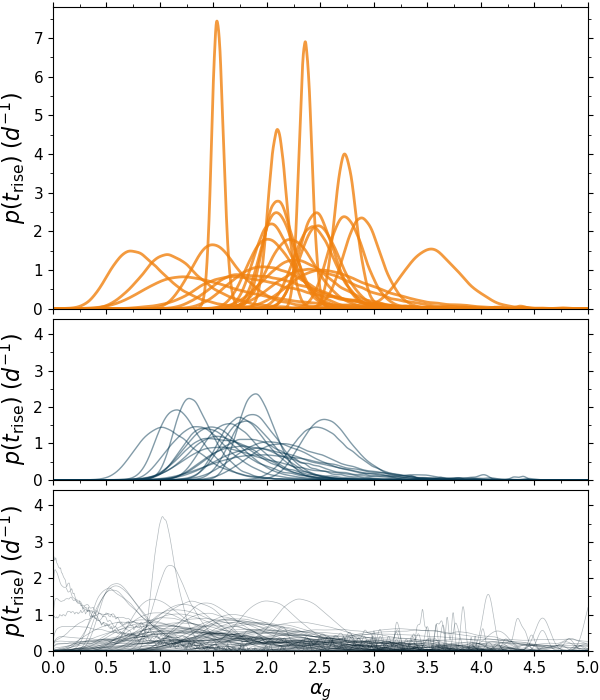

In [78]:
talk_plot = False
if talk_plot:
    figsize = (9,9)
else:
    figsize = (6,7)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, 
                                    figsize=figsize, sharex=True, 
                                    gridspec_kw={'width_ratios': [1],
                                                 'height_ratios':[3,1.6,1.6]})



for pdf in norm_pdf_array[normal_plot]:
    ax3.plot(alpha_grid, np.exp(pdf),
            color=color_dict['dark navy'], lw=0.5, alpha=0.3)
for pdf in norm_pdf_array[normal_good_plot]:
    ax2.plot(alpha_grid, np.exp(pdf),
            color=color_dict['blueberry'], lw=1, alpha=0.5)
for pdf in norm_pdf_array[normal_good_host]:
    ax1.plot(alpha_grid, np.exp(pdf),
            color=color_dict['orange'], lw=2, alpha=0.8)

ax1.set_ylim(0,7.8)
ax2.set_ylim(0,7.8*1.7/3)
ax3.set_ylim(0,7.8*1.7/3)
ax1.xaxis.set_minor_locator(MultipleLocator(0.25))
ax1.xaxis.set_major_locator(MultipleLocator(0.5))

if talk_plot:
    ax1.set_xlim(0.2,4.2)
    ax1.tick_params(top=True, which='both')
    ax3.set_xlabel(r'$\alpha_g$',fontsize=17)

    for ax in [ax1, ax2, ax3]:
        ax.set_ylabel(r'$p(\alpha_g)$',fontsize=17)
        ax.yaxis.set_minor_locator(MultipleLocator(0.5))
        ax.yaxis.set_major_locator(MultipleLocator(1))
        ax.tick_params(right=True, top=False, bottom=True, which='both', labelsize=13)
        ax.vlines(2.0, -10, 10, colors='0.4', linestyles='--')
    
    fig.subplots_adjust(left=0.065,bottom=0.065,top=0.99,right=0.99,hspace=0.05)
else:
    for ax in [ax1, ax2, ax3]:
        ax.set_ylabel(r'$p(t_\mathrm{rise}) \; (d^{-1})$',fontsize=16)
        ax.yaxis.set_minor_locator(MultipleLocator(0.5))
        ax.yaxis.set_major_locator(MultipleLocator(1))
        ax.xaxis.set_minor_locator(MultipleLocator(0.25))
        ax.xaxis.set_major_locator(MultipleLocator(0.5))
        ax.tick_params(right=True, top=False, bottom=True, which='both', labelsize=11)

    ax1.set_xlim(0,5)
    ax1.tick_params(top=True, which='both')
    ax3.set_xlabel(r'$\alpha_g$',fontsize=14)

    fig.subplots_adjust(left=0.088,bottom=0.07,top=0.99,right=0.98,hspace=0.05)

    fig.savefig('../paper/figures/alpha_g.pdf')

In [79]:
flat_alpha_g_05 = np.zeros(len(res))
flat_alpha_g_16 = np.zeros_like(flat_alpha_g_05)
flat_alpha_g_50 = np.zeros_like(flat_alpha_g_05)
flat_alpha_g_84 = np.zeros_like(flat_alpha_g_05)
flat_alpha_g_95 = np.zeros_like(flat_alpha_g_05)

for sn_num, pdf in enumerate(norm_pdf_array):
    cum_prob = np.cumsum(np.exp(pdf)/len(alpha_grid)*np.ptp(alpha_grid))
    idx_05 = np.min(np.where(cum_prob > 0.05)[0])
    flat_alpha_g_95[sn_num] = np.interp(0.05, cum_prob[idx_05-1:idx_05+1], alpha_grid[idx_05-1:idx_05+1])
    idx_16 = np.min(np.where(cum_prob > 0.15865)[0])
    flat_alpha_g_84[sn_num] = np.interp(0.15865, cum_prob[idx_16-1:idx_16+1], alpha_grid[idx_16-1:idx_16+1])
    idx_50 = np.min(np.where(cum_prob > 0.5)[0])
    flat_alpha_g_50[sn_num] = np.interp(0.50, cum_prob[idx_50-1:idx_50+1], alpha_grid[idx_50-1:idx_50+1])
    idx_84 = np.min(np.where(cum_prob > 0.84135)[0])
    flat_alpha_g_16[sn_num] = np.interp(0.84135, cum_prob[idx_84-1:idx_84+1], alpha_grid[idx_84-1:idx_84+1])
    idx_95 = np.min(np.where(cum_prob > 0.95)[0])
    flat_alpha_g_05[sn_num] = np.interp(0.95, cum_prob[idx_95-1:idx_95+1], alpha_grid[idx_95-1:idx_95+1])

In [80]:
res['flat_alpha_g_05'] = flat_alpha_g_05
res['flat_alpha_g_16'] = flat_alpha_g_16
res['flat_alpha_g_50'] = flat_alpha_g_50
res['flat_alpha_g_84'] = flat_alpha_g_84
res['flat_alpha_g_95'] = flat_alpha_g_95

res.to_csv('results_40percent.csv', index=False)

In [81]:
flat_alpha_g_16 = res.flat_alpha_g_16.values.copy()
flat_alpha_g_50 = res.flat_alpha_g_50.values.copy()
flat_alpha_g_84 = res.flat_alpha_g_84.values.copy()

sigma_i = (flat_alpha_g_84-flat_alpha_g_16)/2
w_i = (sigma_i)**(-2)

In [82]:
print('The following are summary statistics for alpha_g:')
print('mean, median, weighted mean: {:.5f}, {:.5f}, {:.5f}'.format(np.mean(flat_alpha_g_50[normal]), np.median(flat_alpha_g_50[normal]),
                                                                   np.average(flat_alpha_g_50[normal], 
                                                                              weights=w_i[normal])))
print('std, sMAD, sigma w_mean: {:.5f}, {:.5f}, {:.5f}'.format(np.std(flat_alpha_g_50[normal], ddof=1), 
                                                       1.4826*np.median(np.abs(flat_alpha_g_50[normal] - np.median(flat_alpha_g_50[normal]))),
                                                       1/np.sum(w_i[normal])*np.sqrt(np.sum((w_i[normal]*sigma_i[normal])**2))))

print('  If you restrict to only "good" SNe however:')
print('    mean, median, weighted mean: {:.5f}, {:.5f}, {:.5f}'.format(np.mean(flat_alpha_g_50[normal_good]), np.median(flat_alpha_g_50[normal_good]),
                                                                   np.average(flat_alpha_g_50[normal_good], 
                                                                              weights=w_i[normal_good])))
print('    std, sMAD, sigma w_mean: {:.5f}, {:.5f}, {:.5f}'.format(np.std(flat_alpha_g_50[normal_good], ddof=1), 
                                                                   1.4826*np.median(np.abs(flat_alpha_g_50[normal_good] - np.median(flat_alpha_g_50[normal_good]))), 
                                                                   1/np.sum(w_i[normal_good])*np.sqrt(np.sum((w_i[normal_good]*sigma_i[normal_good])**2))))

print('\tFurther restrict to host-z SNe however:')
print('\t  mean, median, weighted mean: {:.5f}, {:.5f}, {:.5f}'.format(np.mean(flat_alpha_g_50[normal_good_host]), np.median(flat_alpha_g_50[normal_good_host]),
                                                                   np.average(flat_alpha_g_50[normal_good_host], 
                                                                              weights=w_i[normal_good_host])))
print('\t  std, sMAD, sigma w_mean: {:.5f}, {:.5f}, {:.5f}'.format(np.std(flat_alpha_g_50[normal_good_host], ddof=1), 
                                                                   1.4826*np.median(np.abs(flat_alpha_g_50[normal_good_host] - np.median(flat_alpha_g_50[normal_good_host]))), 
                                                                   1/np.sum(w_i[normal_good_host])*np.sqrt(np.sum((w_i[normal_good_host]*sigma_i[normal_good_host])**2))))

The following are summary statistics for alpha_g:
mean, median, weighted mean: 1.85714, 1.86430, 1.89465
std, sMAD, sigma w_mean: 0.74960, 0.69332, 0.02269
  If you restrict to only "good" SNe however:
    mean, median, weighted mean: 1.99484, 2.04070, 2.05299
    std, sMAD, sigma w_mean: 0.53178, 0.60061, 0.02534
	Further restrict to host-z SNe however:
	  mean, median, weighted mean: 2.16909, 2.11633, 2.11978
	  std, sMAD, sigma w_mean: 0.58515, 0.52788, 0.02793


##  $\alpha_r$ constraints

In [83]:
alpha_grid = np.linspace(0,10,100000)

def get_pdf(tup):

    sn, bw = tup
    sn_num = np.where(salt_df.name == sn)[0]
    
    h5_file = info_path + 'big_unc/{}_emcee_40_varchange.h5'.format(sn)
    reader = emcee.backends.HDFBackend(h5_file)
    thin_by = 100
    nsteps = thin_by*np.shape(reader.get_chain())[0]
    tau = reader.get_autocorr_time(tol=0)
    burnin = int(5*np.max(tau))
    samples = reader.get_chain(discard=burnin, thin=np.max(int(np.max(tau)), 0), flat=True)

    alpha_grid = np.linspace(0,10,100000)
    alpha_r_samples = samples[:,4]
    alpha_r_data = np.reshape(alpha_r_samples, (len(alpha_r_samples), 1))

    kde = KernelDensity(rtol=1e-4, bandwidth = bw)
    kde.fit(alpha_r_data)

    pdf = kde.score_samples(alpha_grid.reshape(100000,1))
    
    
    return pdf

pool = Pool()

alpha_r_res = pool.map(get_pdf, zip(bw_df.ztf_name.values, bw_df.alpha_r_bw.values))

In [84]:
pdf_array_alpha_r = np.array(alpha_r_res)

# divide out the prior
div_prior = pdf_array_alpha_r + np.repeat(np.log(10)*alpha_grid.reshape(1,-1), 127, axis=0)

norm_likelihood = np.sum(np.exp(div_prior), axis=1)/len(alpha_grid)*np.ptp(alpha_grid)
norm_pdf_array = div_prior - np.repeat(np.log(norm_likelihood).reshape(-1,1), len(alpha_grid), axis=1)

<IPython.core.display.Javascript object>


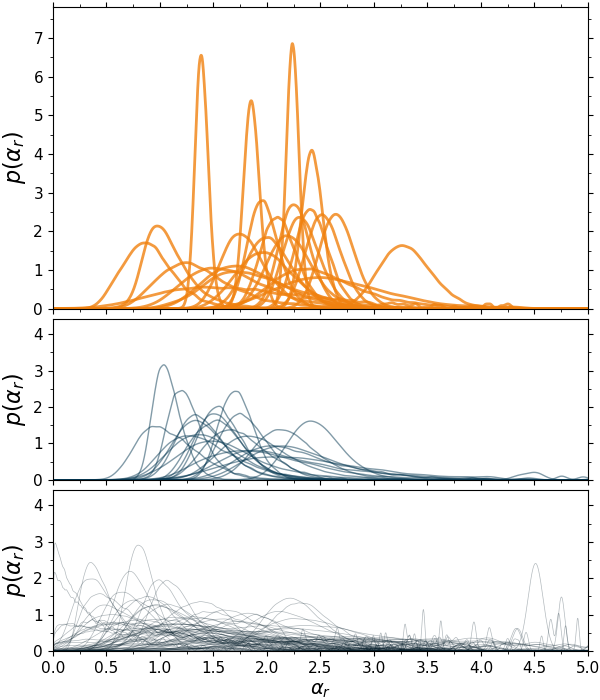

In [85]:
talk_plot = False
if talk_plot:
    figsize = (9,9)
else:
    figsize = (6,7)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, 
                                    figsize=figsize, sharex=True, 
                                    gridspec_kw={'width_ratios': [1],
                                                 'height_ratios':[3,1.6,1.6]})



for pdf in norm_pdf_array[normal_plot]:
    ax3.plot(alpha_grid, np.exp(pdf),
            color=color_dict['dark navy'], lw=0.5, alpha=0.3)
for pdf in norm_pdf_array[normal_good_plot]:
    ax2.plot(alpha_grid, np.exp(pdf),
            color=color_dict['blueberry'], lw=1, alpha=0.5)
for pdf in norm_pdf_array[normal_good_host]:
    ax1.plot(alpha_grid, np.exp(pdf),
            color=color_dict['orange'], lw=2, alpha=0.8)

ax1.set_ylim(0,7.8)
ax2.set_ylim(0,7.8*1.7/3)
ax3.set_ylim(0,7.8*1.7/3)
ax1.xaxis.set_minor_locator(MultipleLocator(0.25))
ax1.xaxis.set_major_locator(MultipleLocator(0.5))

if talk_plot:
    ax1.set_xlim(0.2,4.2)
    ax1.tick_params(top=True, which='both')
    ax3.set_xlabel(r'$\alpha_r$',fontsize=17)

    for ax in [ax1, ax2, ax3]:
        ax.set_ylabel(r'$p(\alpha_r)$',fontsize=17)
        ax.yaxis.set_minor_locator(MultipleLocator(0.5))
        ax.yaxis.set_major_locator(MultipleLocator(1))
        ax.tick_params(right=True, top=False, bottom=True, which='both', labelsize=13)
        ax.vlines(2.0, -10, 10, colors='0.4', linestyles='--')
    
    fig.subplots_adjust(left=0.065,bottom=0.065,top=0.99,right=0.99,hspace=0.05)
else:
    for ax in [ax1, ax2, ax3]:
        ax.set_ylabel(r'$p(\alpha_r)$',fontsize=16)
        ax.yaxis.set_minor_locator(MultipleLocator(0.5))
        ax.yaxis.set_major_locator(MultipleLocator(1))
        ax.xaxis.set_minor_locator(MultipleLocator(0.25))
        ax.xaxis.set_major_locator(MultipleLocator(0.5))
        ax.tick_params(right=True, top=False, bottom=True, which='both', labelsize=11)

    ax1.set_xlim(0,5)
    ax1.tick_params(top=True, which='both')
    ax3.set_xlabel(r'$\alpha_r$',fontsize=14)

    fig.subplots_adjust(left=0.088,bottom=0.07,top=0.99,right=0.98,hspace=0.05)

    fig.savefig('../paper/figures/alpha_r.pdf')

In [86]:
flat_alpha_r_05 = np.zeros(len(res))
flat_alpha_r_16 = np.zeros_like(flat_alpha_r_05)
flat_alpha_r_50 = np.zeros_like(flat_alpha_r_05)
flat_alpha_r_84 = np.zeros_like(flat_alpha_r_05)
flat_alpha_r_95 = np.zeros_like(flat_alpha_r_05)

for sn_num, pdf in enumerate(norm_pdf_array):
    cum_prob = np.cumsum(np.exp(pdf)/len(alpha_grid)*np.ptp(alpha_grid))
    idx_05 = np.min(np.where(cum_prob > 0.05)[0])
    flat_alpha_r_95[sn_num] = np.interp(0.05, cum_prob[idx_05-1:idx_05+1], alpha_grid[idx_05-1:idx_05+1])
    idx_16 = np.min(np.where(cum_prob > 0.15865)[0])
    flat_alpha_r_84[sn_num] = np.interp(0.15865, cum_prob[idx_16-1:idx_16+1], alpha_grid[idx_16-1:idx_16+1])
    idx_50 = np.min(np.where(cum_prob > 0.5)[0])
    flat_alpha_r_50[sn_num] = np.interp(0.50, cum_prob[idx_50-1:idx_50+1], alpha_grid[idx_50-1:idx_50+1])
    idx_84 = np.min(np.where(cum_prob > 0.84135)[0])
    flat_alpha_r_16[sn_num] = np.interp(0.84135, cum_prob[idx_84-1:idx_84+1], alpha_grid[idx_84-1:idx_84+1])
    idx_95 = np.min(np.where(cum_prob > 0.95)[0])
    flat_alpha_r_05[sn_num] = np.interp(0.95, cum_prob[idx_95-1:idx_95+1], alpha_grid[idx_95-1:idx_95+1])

In [87]:
res['flat_alpha_r_05'] = flat_alpha_r_05
res['flat_alpha_r_16'] = flat_alpha_r_16
res['flat_alpha_r_50'] = flat_alpha_r_50
res['flat_alpha_r_84'] = flat_alpha_r_84
res['flat_alpha_r_95'] = flat_alpha_r_95

res.to_csv('results_40percent.csv', index=False)

In [88]:
flat_alpha_r_16 = res.flat_alpha_r_16.values.copy()
flat_alpha_r_50 = res.flat_alpha_r_50.values.copy()
flat_alpha_r_84 = res.flat_alpha_r_84.values.copy()

sigma_i = (flat_alpha_r_84-flat_alpha_r_16)/2
w_i = (sigma_i)**(-2)

In [89]:
print('The following are summary statistics for alpha_r:')
print('mean, median, weighted mean: {:.5f}, {:.5f}, {:.5f}'.format(np.mean(flat_alpha_r_50[normal]), np.median(flat_alpha_r_50[normal]),
                                                                   np.average(flat_alpha_r_50[normal], 
                                                                              weights=w_i[normal])))
print('std, sMAD, sigma w_mean: {:.5f}, {:.5f}, {:.5f}'.format(np.std(flat_alpha_r_50[normal], ddof=1), 
                                                       1.4826*np.median(np.abs(flat_alpha_r_50[normal] - np.median(flat_alpha_r_50[normal]))),
                                                       1/np.sum(w_i[normal])*np.sqrt(np.sum((w_i[normal]*sigma_i[normal])**2))))

print('  If you restrict to only "good" SNe however:')
print('    mean, median, weighted mean: {:.5f}, {:.5f}, {:.5f}'.format(np.mean(flat_alpha_r_50[normal_good]), np.median(flat_alpha_r_50[normal_good]),
                                                                   np.average(flat_alpha_r_50[normal_good], 
                                                                              weights=w_i[normal_good])))
print('    std, sMAD, sigma w_mean: {:.5f}, {:.5f}, {:.5f}'.format(np.std(flat_alpha_r_50[normal_good], ddof=1), 
                                                                   1.4826*np.median(np.abs(flat_alpha_r_50[normal_good] - np.median(flat_alpha_r_50[normal_good]))), 
                                                                   1/np.sum(w_i[normal_good])*np.sqrt(np.sum((w_i[normal_good]*sigma_i[normal_good])**2))))

print('\tFurther restrict to host-z SNe however:')
print('\t  mean, median, weighted mean: {:.5f}, {:.5f}, {:.5f}'.format(np.mean(flat_alpha_r_50[normal_good_host]), np.median(flat_alpha_r_50[normal_good_host]),
                                                                   np.average(flat_alpha_r_50[normal_good_host], 
                                                                              weights=w_i[normal_good_host])))
print('\t  std, sMAD, sigma w_mean: {:.5f}, {:.5f}, {:.5f}'.format(np.std(flat_alpha_r_50[normal_good_host], ddof=1), 
                                                                   1.4826*np.median(np.abs(flat_alpha_r_50[normal_good_host] - np.median(flat_alpha_r_50[normal_good_host]))), 
                                                                   1/np.sum(w_i[normal_good_host])*np.sqrt(np.sum((w_i[normal_good_host]*sigma_i[normal_good_host])**2))))

The following are summary statistics for alpha_r:
mean, median, weighted mean: 1.75008, 1.65442, 1.73165
std, sMAD, sigma w_mean: 0.79953, 0.82024, 0.02201
  If you restrict to only "good" SNe however:
    mean, median, weighted mean: 1.88306, 1.85717, 1.89450
    std, sMAD, sigma w_mean: 0.50188, 0.56953, 0.02476
	Further restrict to host-z SNe however:
	  mean, median, weighted mean: 2.03314, 2.02495, 1.99010
	  std, sMAD, sigma w_mean: 0.53646, 0.44773, 0.02783


## $\alpha_r - \alpha_g$

In [92]:
delta_grid = np.linspace(-4,4,100000)

def get_pdf(tup):

    sn, bw = tup
    sn_num = np.where(salt_df.name == sn)[0]
    
#     h5_file = info_path + 'big_unc/{}_emcee_40_varchange.h5'.format(sn)
#     reader = emcee.backends.HDFBackend(h5_file)
#     thin_by = 100
#     nsteps = thin_by*np.shape(reader.get_chain())[0]
#     tau = reader.get_autocorr_time(tol=0)
#     burnin = int(5*np.max(tau))
#     samples = reader.get_chain(discard=burnin, thin=np.max(int(np.max(tau)), 0), flat=True)

    delta_df = pd.read_hdf(info_path + 'big_unc/{}_uninformative_deltas.h5'.format(sn))
    delta = delta_df.delta.values   

    delta_grid = np.linspace(-4,4,100000)
    delta_data = np.reshape(delta, (len(delta), 1))

    kde = KernelDensity(rtol=1e-4, bandwidth = bw)
    kde.fit(delta_data)

    pdf = kde.score_samples(delta_grid.reshape(100000,1))
    
    
    return pdf

pool = Pool()

delta_res = pool.map(get_pdf, zip(bw_df.ztf_name.values, bw_df.delta_bw.values))

In [93]:
pdf_array_ratio = np.array(delta_res)

# divide out the prior
# div_prior = pdf_array_ratio + np.repeat(np.log(10)*ratio_grid.reshape(1,-1), 127, axis=0)

norm_likelihood = np.sum(np.exp(pdf_array_ratio), axis=1)/len(delta_grid)*np.ptp(delta_grid)
norm_pdf_array = pdf_array_ratio - np.repeat(np.log(norm_likelihood).reshape(-1,1), len(delta_grid), axis=1)

<IPython.core.display.Javascript object>


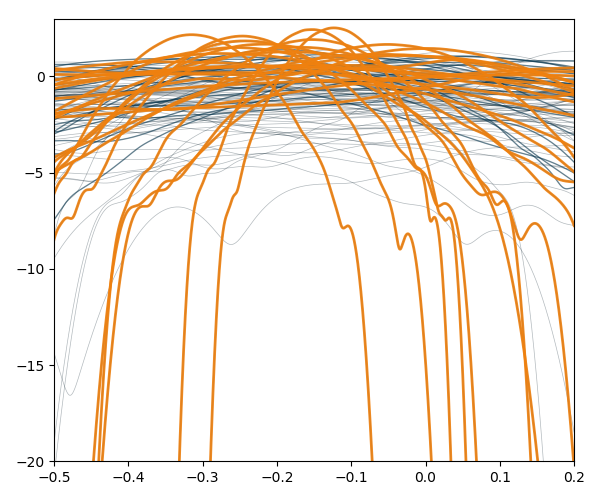

In [94]:
fig, ax = plt.subplots(figsize=(6,5))
for pdf in norm_pdf_array[normal]:
    ax.plot(delta_grid, pdf, 
            color=color_dict['dark navy'], lw=0.5, alpha=0.3)
for pdf in norm_pdf_array[normal_good]:
    ax.plot(delta_grid, pdf, 
            color=color_dict['blueberry'], lw=1, alpha=0.5)
for pdf in norm_pdf_array[normal_good_host]:
    ax.plot(delta_grid, pdf, 
            color=color_dict['orange'], lw=2, alpha=0.9)
ax.set_ylim(-20,3)
ax.set_xlim(-0.5,0.2)
fig.tight_layout()

In [96]:
mean_delta = np.sum(norm_pdf_array[normal_good_host], axis=0)
mean_delta_reliable = np.sum(norm_pdf_array[normal_good], axis=0)
mean_delta_unreliable = np.sum(norm_pdf_array[normal], axis=0)

norm_mean = np.sum(np.exp(mean_delta))/len(delta_grid)*np.ptp(delta_grid)
norm_mean_reliable = np.sum(np.exp(mean_delta_reliable))/len(delta_grid)*np.ptp(delta_grid)

mean_pdf_delta = mean_delta - np.repeat(np.log(norm_mean), len(delta_grid))
mean_pdf_delta_reliable = mean_delta_reliable - np.repeat(np.log(norm_mean_reliable), len(delta_grid))

<IPython.core.display.Javascript object>


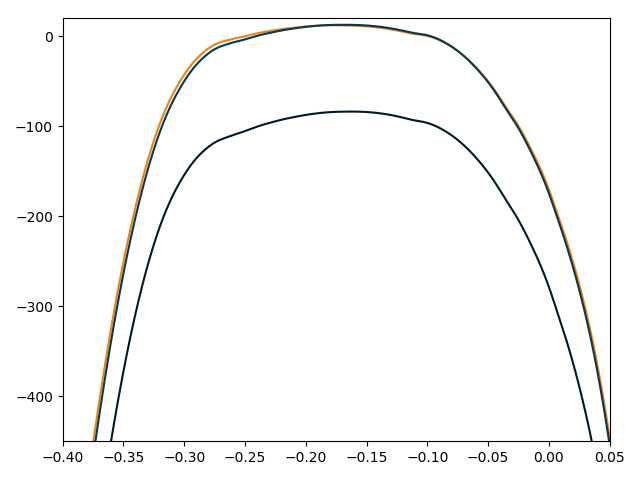

In [97]:
plt.figure()
plt.plot(delta_grid, mean_delta, color=color_dict['orange'])
plt.plot(delta_grid, mean_delta_reliable, color=color_dict['blueberry'])
plt.plot(delta_grid, mean_delta_unreliable, color=color_dict['dark navy'])
plt.xlim(-0.4,0.05)
plt.ylim(-450,20)
plt.tight_layout()

In [98]:
cdf_good_host = np.cumsum(np.exp(mean_pdf_delta)/len(delta_grid)*np.ptp(delta_grid))
cdf_reliable = np.cumsum(np.exp(mean_pdf_delta_reliable)/len(delta_grid)*np.ptp(delta_grid))

print(np.interp([.16,.50,.84], cdf_good_host, delta_grid)) #  reliable host-z
print(np.interp([.16,.50,.84], cdf_reliable, delta_grid)) #  reliable

[-0.19042168 -0.17526158 -0.15888676]
[-0.18370684 -0.16919185 -0.15465089]


<IPython.core.display.Javascript object>


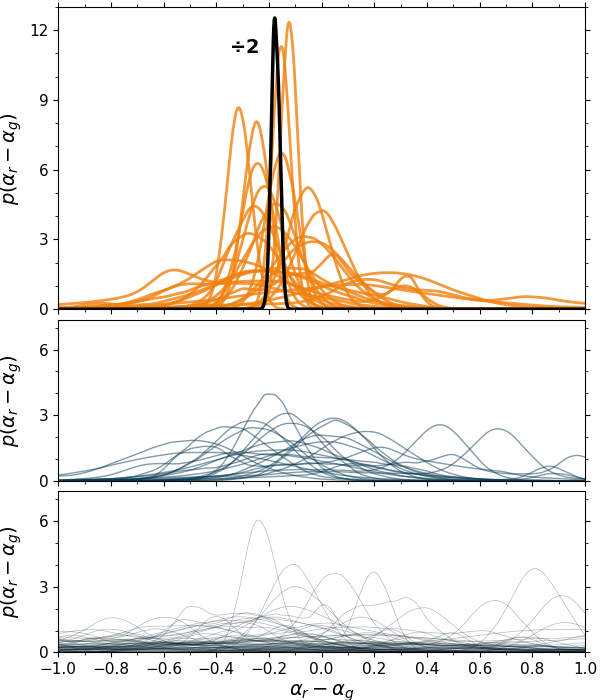

In [99]:
talk_plot = False
if talk_plot:
    figsize = (9,9)
else:
    figsize = (6,7)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, 
                                    figsize=figsize, sharex=True, 
                                    gridspec_kw={'width_ratios': [1],
                                                 'height_ratios':[3,1.6,1.6]})



for pdf in norm_pdf_array[normal_plot]:
    ax3.plot(delta_grid, np.exp(pdf),
            color=color_dict['dark navy'], lw=0.5, alpha=0.3)
for pdf in norm_pdf_array[normal_good_plot]:
    ax2.plot(delta_grid, np.exp(pdf),
            color=color_dict['blueberry'], lw=1, alpha=0.5)
for pdf in norm_pdf_array[normal_good_host]:
    ax1.plot(delta_grid, np.exp(pdf),
            color=color_dict['orange'], lw=2, alpha=0.8)
ax1.plot(delta_grid, np.exp(mean_pdf_delta)/2, lw=2.5, color='k') # plot black line in all panels

ax1.set_ylim(0,13)
ax2.set_ylim(0,13*1.7/3)
ax3.set_ylim(0,13*1.7/3)
ax1.xaxis.set_minor_locator(MultipleLocator(0.1))
ax1.xaxis.set_major_locator(MultipleLocator(0.2))

if talk_plot:
    ax1.set_xlim(-1,1)
    ax3.set_xlabel(r'$\alpha_r - \alpha_g$',fontsize=19)

    for ax in [ax1, ax2, ax3]:
        ax.set_ylabel(r'$p(\alpha_r - \alpha_g)$',fontsize=19)
        ax.yaxis.set_minor_locator(MultipleLocator(1))
        ax.yaxis.set_major_locator(MultipleLocator(3))
        ax.tick_params(right=True, top=False, bottom=True, which='both', labelsize=15)
    
    ax1.tick_params(top=True, which='both')
    fig.subplots_adjust(left=0.085,bottom=0.07,top=0.99,right=0.98,hspace=0.05)
    fig.align_ylabels()
else:
    ax1.text(-0.35, 11, r'$\mathbf{\div 2}$', fontsize=14)
    ax1.set_xlim(-1,1)
    ax3.set_xlabel(r'$\alpha_r - \alpha_g$',fontsize=14)

    for ax in [ax1, ax2, ax3]:
        ax.set_ylabel(r'$p(\alpha_r - \alpha_g)$',fontsize=14)
        ax.yaxis.set_minor_locator(MultipleLocator(1))
        ax.yaxis.set_major_locator(MultipleLocator(3))
        ax.tick_params(right=True, top=False, bottom=True, which='both', labelsize=11)

    ax1.tick_params(top=True, which='both')
    fig.subplots_adjust(left=0.097,bottom=0.068,top=0.99,right=0.975,hspace=0.05)
    fig.align_ylabels()
    fig.savefig('../paper/figures/delta.pdf')

In [100]:
flat_delta_05 = np.zeros(len(res))
flat_delta_16 = np.zeros_like(flat_delta_05)
flat_delta_50 = np.zeros_like(flat_delta_05)
flat_delta_84 = np.zeros_like(flat_delta_05)
flat_delta_95 = np.zeros_like(flat_delta_05)

for sn_num, pdf in enumerate(norm_pdf_array):
    cum_prob = np.cumsum(np.exp(pdf)/len(delta_grid)*np.ptp(delta_grid))
    idx_05 = np.min(np.where(cum_prob > 0.05)[0])
    flat_delta_95[sn_num] = np.interp(0.05, cum_prob[idx_05-1:idx_05+1], delta_grid[idx_05-1:idx_05+1])
    idx_16 = np.min(np.where(cum_prob > 0.15865)[0])
    flat_delta_84[sn_num] = np.interp(0.15865, cum_prob[idx_16-1:idx_16+1], delta_grid[idx_16-1:idx_16+1])
    idx_50 = np.min(np.where(cum_prob > 0.5)[0])
    flat_delta_50[sn_num] = np.interp(0.50, cum_prob[idx_50-1:idx_50+1], delta_grid[idx_50-1:idx_50+1])
    idx_84 = np.min(np.where(cum_prob > 0.84135)[0])
    flat_delta_16[sn_num] = np.interp(0.84135, cum_prob[idx_84-1:idx_84+1], delta_grid[idx_84-1:idx_84+1])
    idx_95 = np.min(np.where(cum_prob > 0.95)[0])
    flat_delta_05[sn_num] = np.interp(0.95, cum_prob[idx_95-1:idx_95+1], delta_grid[idx_95-1:idx_95+1])

In [101]:
res['flat_delta_05'] = flat_delta_05
res['flat_delta_16'] = flat_delta_16
res['flat_delta_50'] = flat_delta_50
res['flat_delta_84'] = flat_delta_84
res['flat_delta_95'] = flat_delta_95

res.to_csv('results_40percent.csv', index=False)

In [102]:
flat_delta_16 = res.flat_delta_16.values.copy()
flat_delta_50 = res.flat_delta_50.values.copy()
flat_delta_84 = res.flat_delta_84.values.copy()

sigma_i = (flat_delta_84-flat_delta_16)/2
w_i = (sigma_i)**(-2)

In [103]:
print('The following are summary statistics for delta:')
print('mean, median, weighted mean: {:.5f}, {:.5f}, {:.5f}'.format(np.mean(flat_delta_50[normal]), np.median(flat_delta_50[normal]),
                                                                   np.average(flat_delta_50[normal], 
                                                                              weights=w_i[normal])))
print('std, sMAD, sigma w_mean: {:.5f}, {:.5f}, {:.5f}'.format(np.std(flat_delta_50[normal], ddof=1), 
                                                       1.4826*np.median(np.abs(flat_delta_50[normal] - np.median(flat_delta_50[normal]))),
                                                       1/np.sum(w_i[normal])*np.sqrt(np.sum((w_i[normal]*sigma_i[normal])**2))))

print('  If you restrict to only "good" SNe however:')
print('    mean, median, weighted mean: {:.5f}, {:.5f}, {:.5f}'.format(np.mean(flat_delta_50[normal_good]), np.median(flat_delta_50[normal_good]),
                                                                   np.average(flat_delta_50[normal_good], 
                                                                              weights=w_i[normal_good])))
print('    std, sMAD, sigma w_mean: {:.5f}, {:.5f}, {:.5f}'.format(np.std(flat_delta_50[normal_good], ddof=1), 
                                                                   1.4826*np.median(np.abs(flat_delta_50[normal_good] - np.median(flat_delta_50[normal_good]))), 
                                                                   1/np.sum(w_i[normal_good])*np.sqrt(np.sum((w_i[normal_good]*sigma_i[normal_good])**2))))

print('\tFurther restrict to host-z SNe however:')
print('\t  mean, median, weighted mean: {:.5f}, {:.5f}, {:.5f}'.format(np.mean(flat_delta_50[normal_good_host]), np.median(flat_delta_50[normal_good_host]),
                                                                   np.average(flat_delta_50[normal_good_host], 
                                                                              weights=w_i[normal_good_host])))
print('\t  std, sMAD, sigma w_mean: {:.5f}, {:.5f}, {:.5f}'.format(np.std(flat_delta_50[normal_good_host], ddof=1), 
                                                                   1.4826*np.median(np.abs(flat_delta_50[normal_good_host] - np.median(flat_delta_50[normal_good_host]))), 
                                                                   1/np.sum(w_i[normal_good_host])*np.sqrt(np.sum((w_i[normal_good_host]*sigma_i[normal_good_host])**2))))

The following are summary statistics for delta:
mean, median, weighted mean: -0.12007, -0.15099, -0.17506
std, sMAD, sigma w_mean: 0.73100, 0.33593, 0.01309
  If you restrict to only "good" SNe however:
    mean, median, weighted mean: -0.09892, -0.14988, -0.16868
    std, sMAD, sigma w_mean: 0.23329, 0.17598, 0.01434
	Further restrict to host-z SNe however:
	  mean, median, weighted mean: -0.13926, -0.17779, -0.17617
	  std, sMAD, sigma w_mean: 0.17131, 0.11590, 0.01534


### Drawing from a 2D distribution to get $\alpha_r - \alpha_g$


The example for drawing from the 2d posterior $\longrightarrow$ likelihood to get $\alpha_r - \alpha_g$. This has been scripted, and results for the full population are shown above. (The below cells show an example for a single variate)

In [177]:
# sn = 'ZTF18aazabmh'
sn = 'ZTF18abauprj'
sn_num = np.where(salt_df.name == sn)[0]

h5_file = info_path + 'big_unc/{}_emcee_40_varchange.h5'.format(sn)
reader = emcee.backends.HDFBackend(h5_file)
thin_by = 100
nsteps = thin_by*np.shape(reader.get_chain())[0]
tau = reader.get_autocorr_time(tol=0)
burnin = int(5*np.max(tau))
samples = reader.get_chain(discard=burnin, thin=np.max(int(np.max(tau)), 0), flat=True)

In [178]:
X = samples[:,(2,4)]

kde = KernelDensity(rtol=1e-4, bandwidth=0.03)

kde.fit(X)

KernelDensity(algorithm='auto', atol=0, bandwidth=0.03, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0.0001)

In [179]:
xx, yy = np.mgrid[0:7.5:0.0075, 
                  0:7.5:0.0075]

xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T

In [180]:
z = kde.score_samples(xy_sample)

In [181]:
zz = np.reshape(z, xx.shape)

<IPython.core.display.Javascript object>


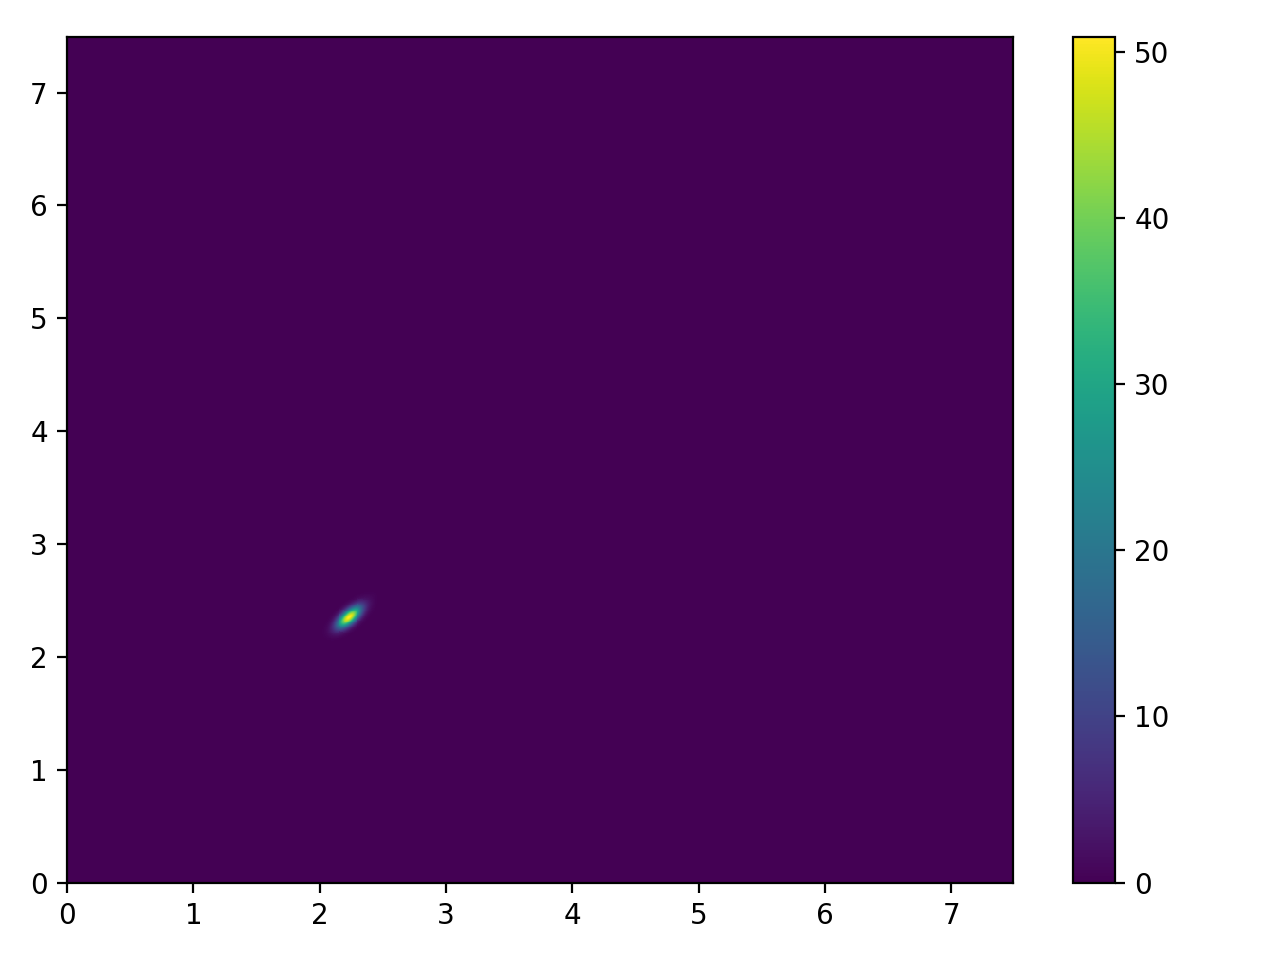

In [182]:
plt.figure()
plt.pcolormesh(xx,yy,np.exp(zz))
# plt.ylim(2.1,2.6)
# plt.xlim(2.1,2.6)
plt.colorbar()
plt.tight_layout()

<IPython.core.display.Javascript object>


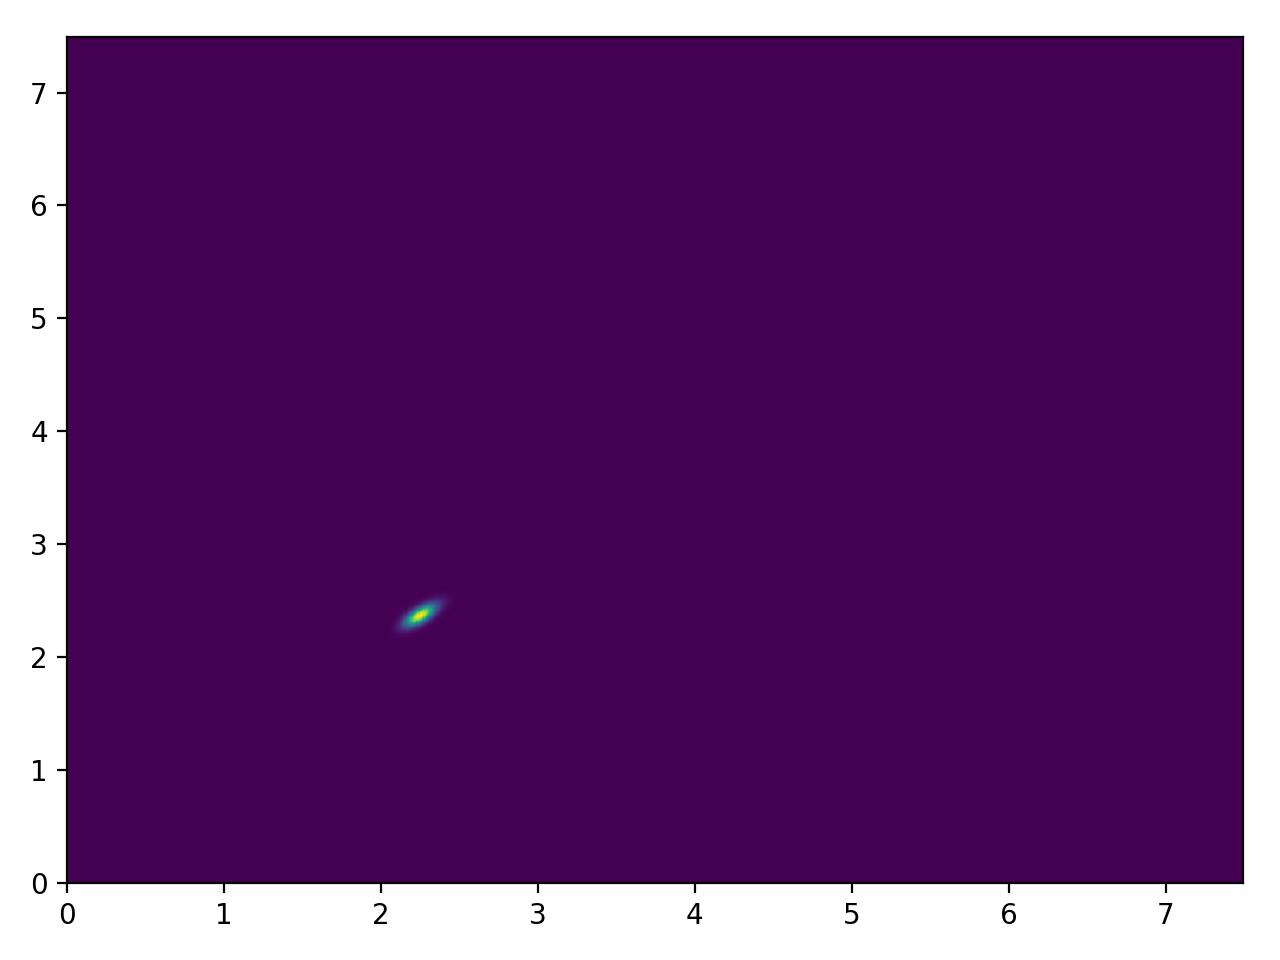

In [187]:
plt.figure()
plt.pcolormesh(xx, yy, np.exp(zz)*10**(xx+yy))
# plt.ylim(2.1,2.6)
# plt.xlim(2.1,2.6)
plt.tight_layout()

<IPython.core.display.Javascript object>


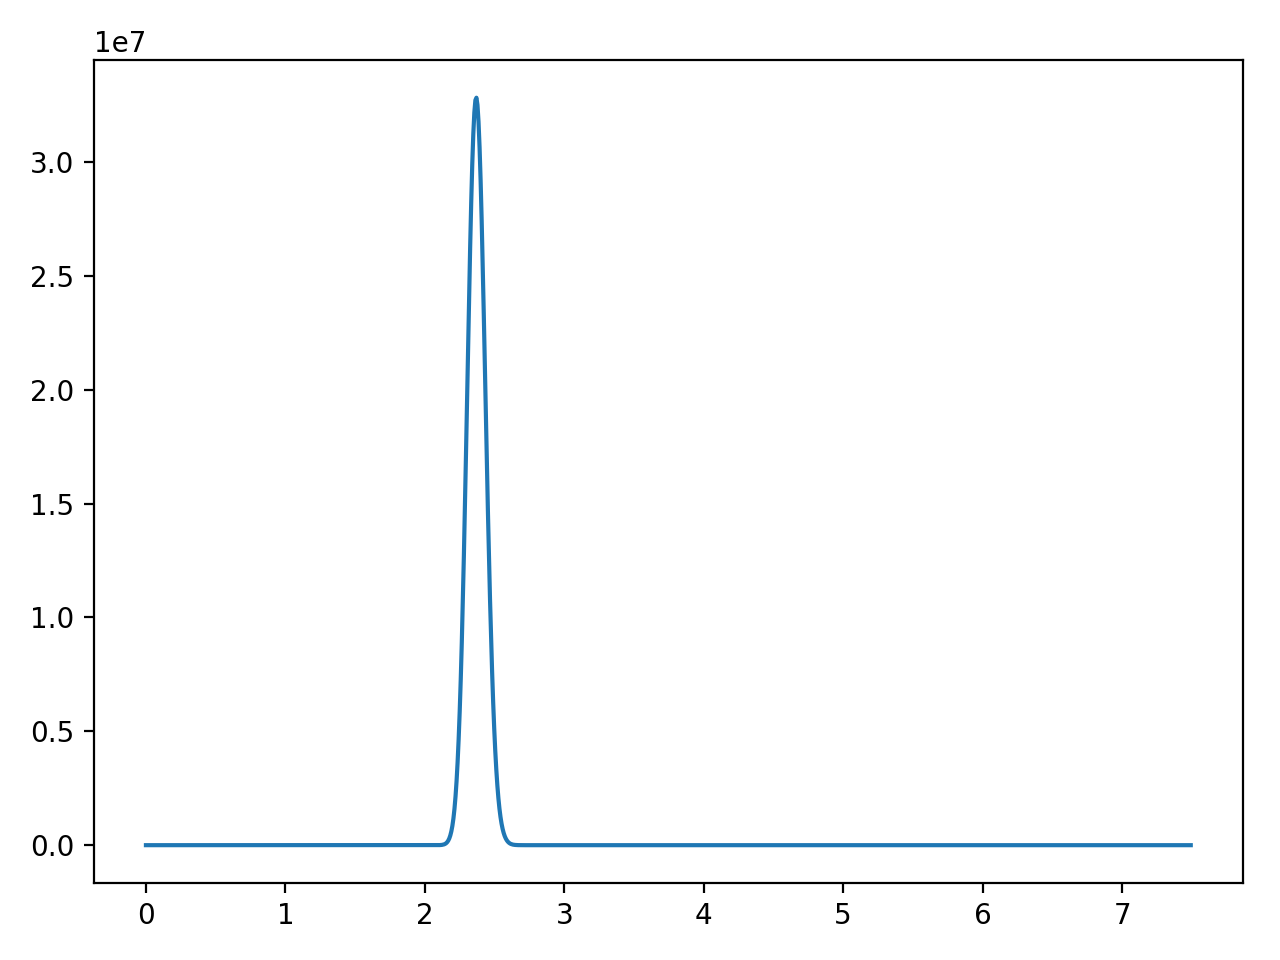

In [188]:
# collapse everything along x-axis
plt.figure()
plt.plot(xx[:,0], np.sum(np.exp(zz)*10**(xx+yy), axis=0)) # sum along x-axis
plt.tight_layout()

<IPython.core.display.Javascript object>


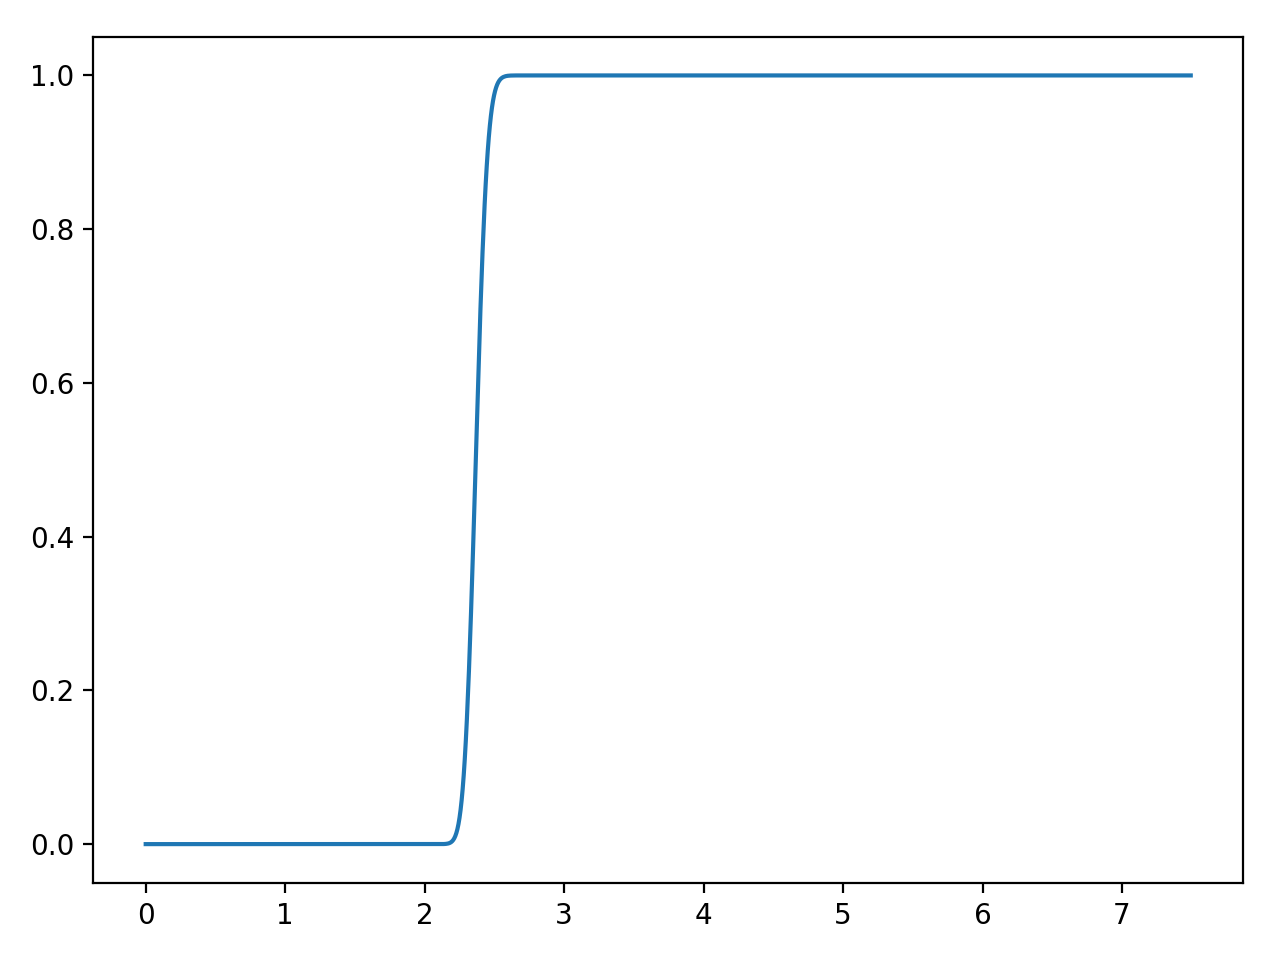

In [189]:
plt.figure()
cdf = np.cumsum(np.sum(np.exp(zz)*10**(xx+yy), axis=0))
plt.plot(xx[:,0], cdf/cdf[-1]) # sum along x-axis
plt.tight_layout()

In [190]:
rand_uni = np.random.uniform(size=len(samples))
alpha_g = np.interp(rand_uni, cdf/cdf[-1], xx[:,0])

<IPython.core.display.Javascript object>


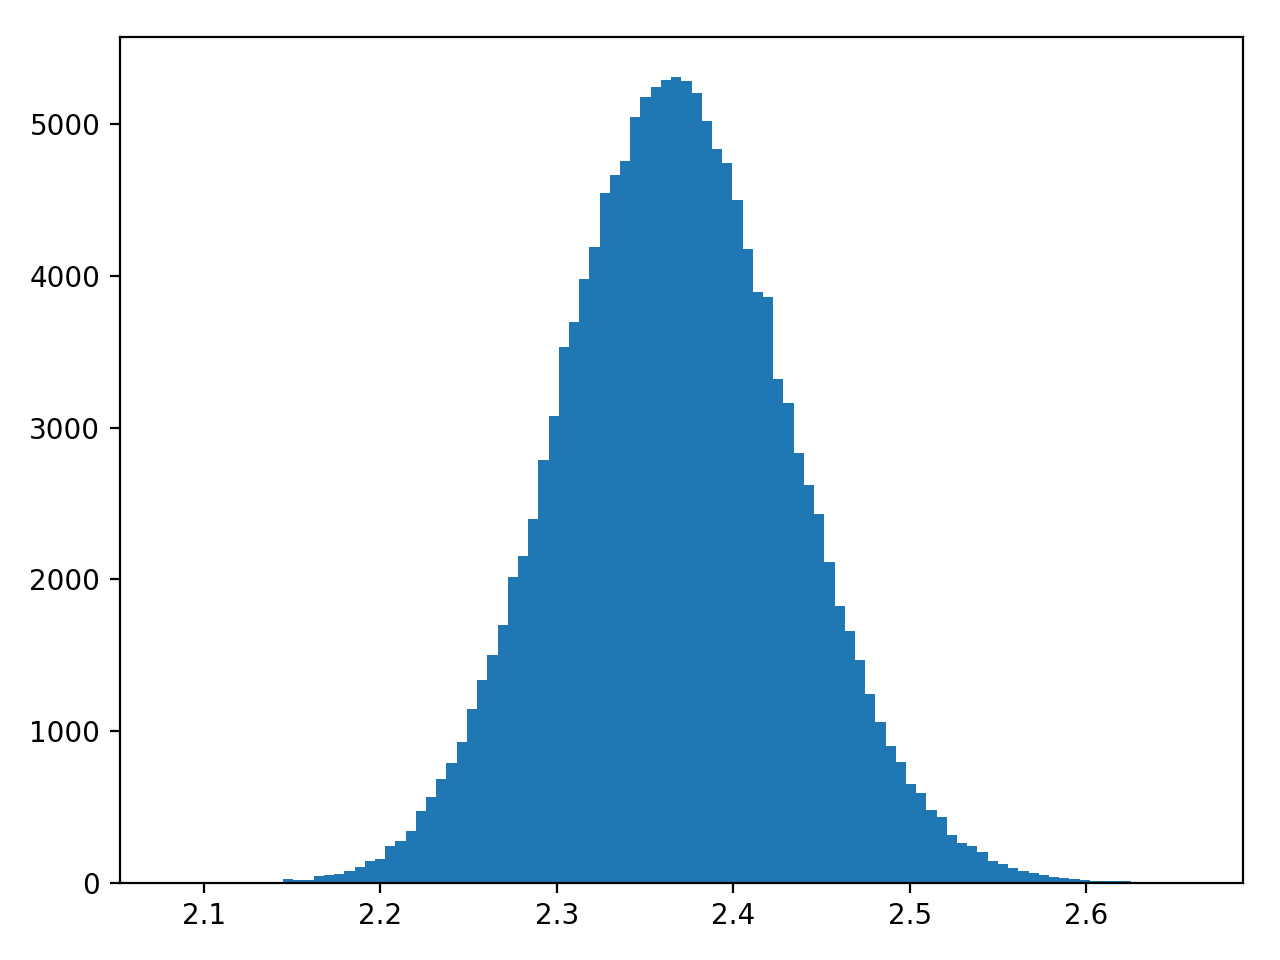

In [192]:
plt.figure()
_ = plt.hist(alpha_g, bins=100)
plt.tight_layout()

In [193]:
from scipy.interpolate import RectBivariateSpline

f = RectBivariateSpline(xx[:,0], yy[0], np.exp(zz)*10**(xx+yy))

In [194]:
alpha_g[0]

2.3223062984576934

In [195]:
haha = f(yy[0], alpha_g[0])

<IPython.core.display.Javascript object>


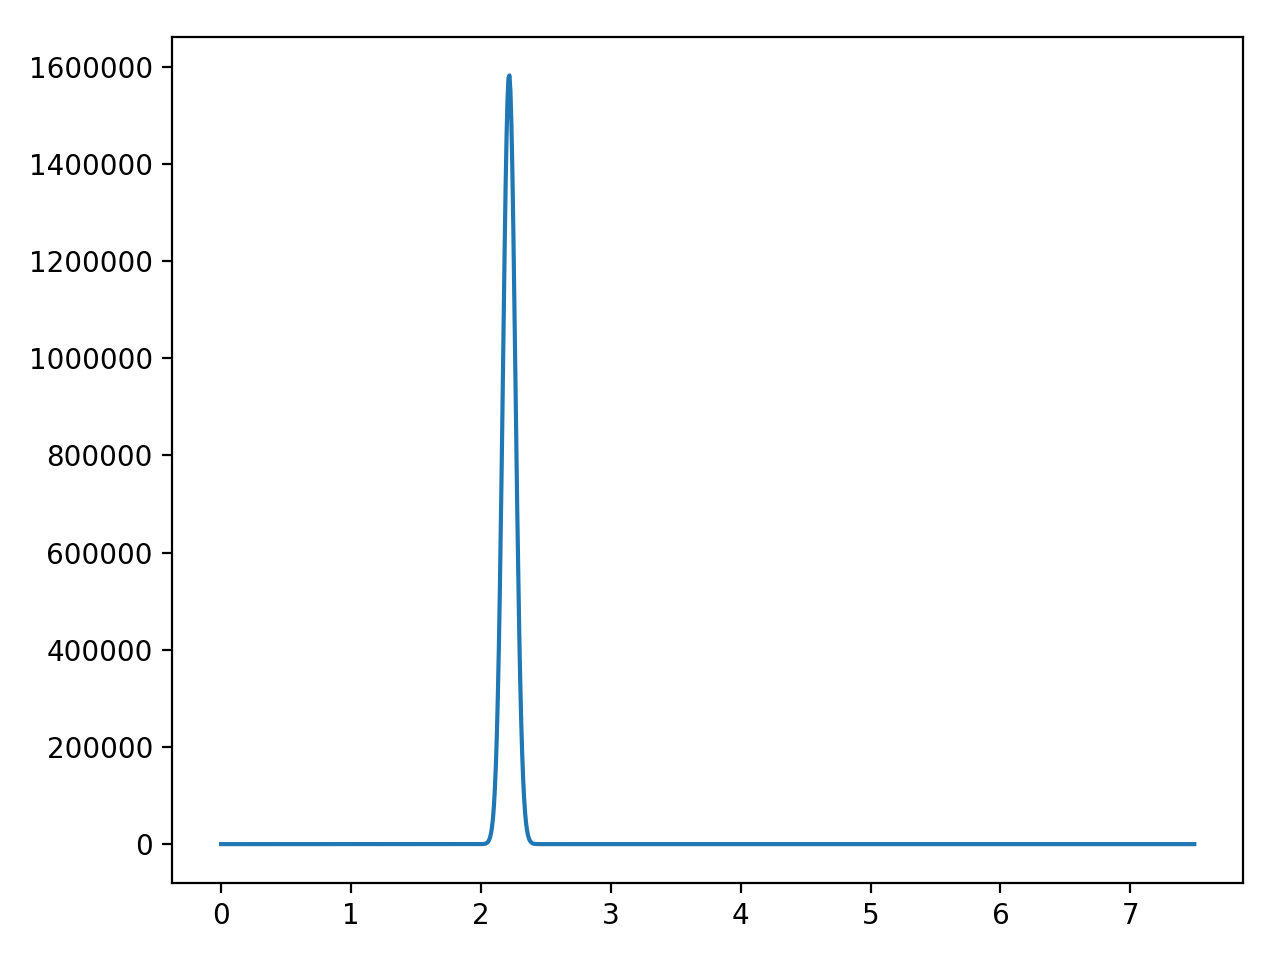

In [197]:
plt.figure()
plt.plot(yy[0], haha[:,0])
plt.tight_layout()

<IPython.core.display.Javascript object>


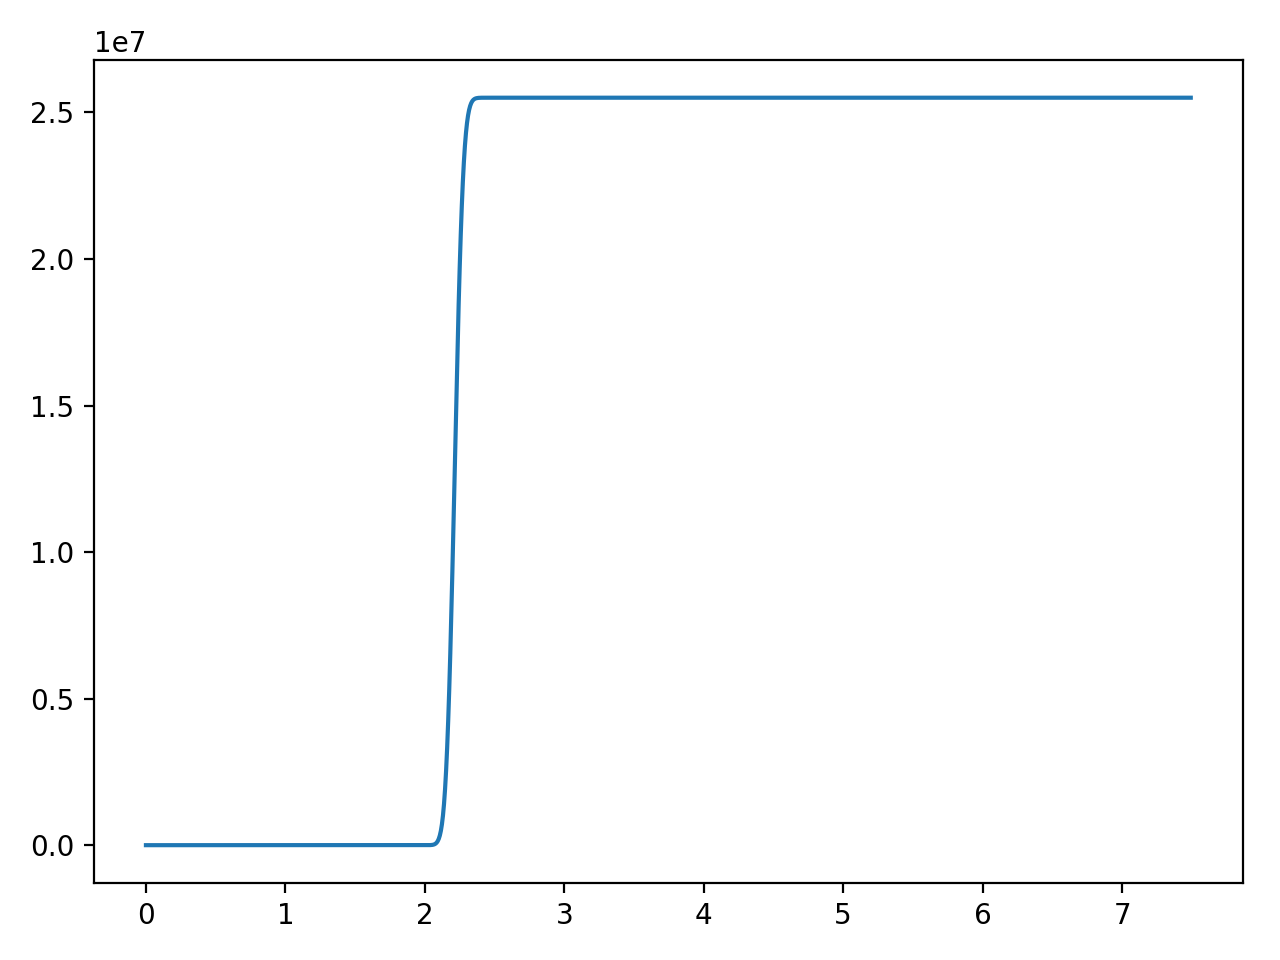

In [198]:
cdf_alpha_r = np.cumsum(haha[:,0])

plt.figure()
plt.plot(yy[0], cdf_alpha_r)
plt.tight_layout()

In [199]:
rand_num = np.random.uniform()
alpha_r = np.interp(rand_num, cdf_alpha_r/cdf_alpha_r[-1], yy[0])

In [200]:
alpha_r

2.0906511515148996

In [201]:
# loop to get all the alpha_r

alpha_r = np.zeros_like(alpha_g)

for al_num, al in enumerate(alpha_g):
    pdf_r = f(yy[0], al)
    cdf_r = np.cumsum(pdf_r[:,0])
    rand_num = np.random.uniform()
    alpha_r[al_num] = np.interp(rand_num, cdf_r/cdf_r[-1], yy[0])

<IPython.core.display.Javascript object>


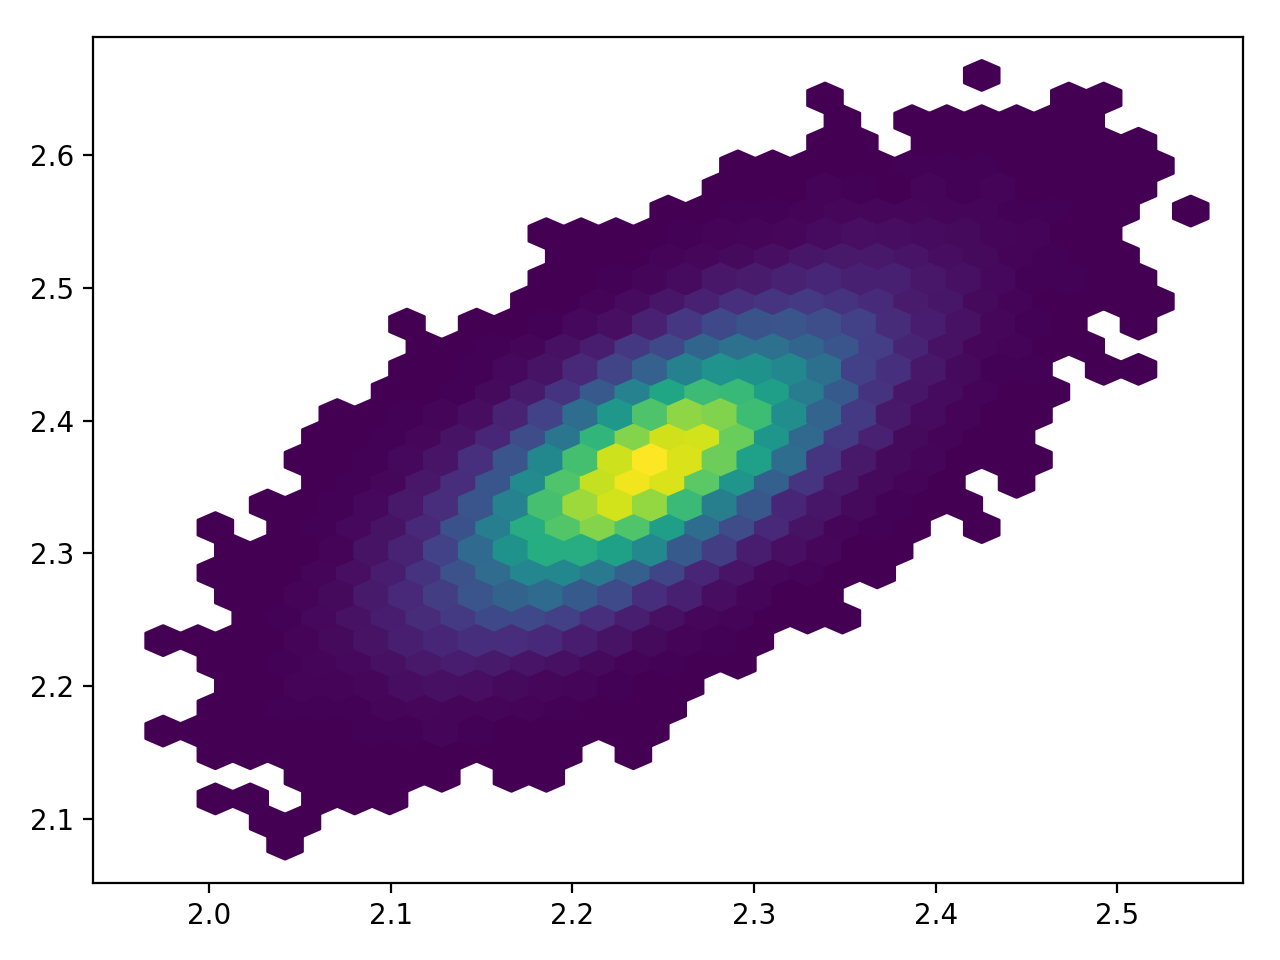

In [203]:
plt.figure()
plt.hexbin(alpha_r,alpha_g, gridsize=30, mincnt=1)
plt.tight_layout()

<IPython.core.display.Javascript object>


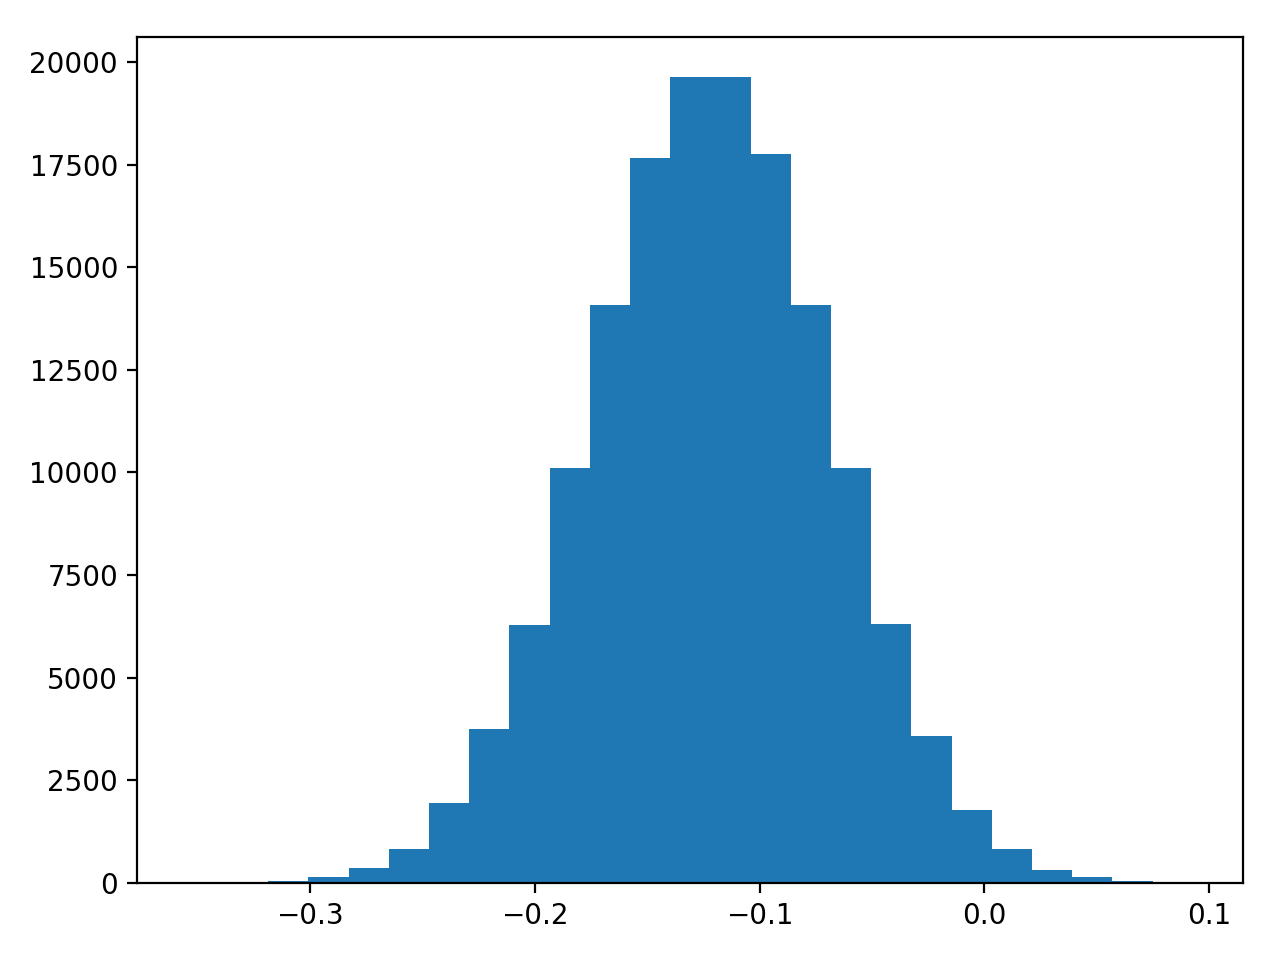

In [204]:
plt.figure()
plt.hist(alpha_r - alpha_g, bins=25)
plt.tight_layout()

In [205]:
delta = alpha_r - alpha_g
delta_df = pd.DataFrame(delta, columns=['delta'])